<a href="https://colab.research.google.com/github/sigeisler/robustness_of_gnns_at_scale/blob/notebook/notebooks/Quick_start_robustness_gnns_at_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robustness of Graph Neural Networks at Scale - Quick Start

This notebook can be run in google colab and serves as a quick introduction to the [Robustness of Graph Neural Networks at Scale](https://github.com/sigeisler/robustness_of_gnns_at_scale) repository.

## 0. Setup

First, let's get the code and install requirements.


In [ ]:
# clone package repository
!git clone https://github.com/sigeisler/robustness_of_gnns_at_scale.git

# navigate to the repository
%cd robustness_of_gnns_at_scale

# install package requirements
!pip install -r requirements.txt
!pip install -r requirements-dev.txt

# install package
# !python setup.py install
!pip install --use-feature=in-tree-build .

# build kernels
!pip install --use-feature=in-tree-build ./kernels

### Imports

In [ ]:
from matplotlib import pyplot as plt

from experiments import (
    experiment_train, 
    experiment_local_attack_direct, 
    experiment_global_attack_direct
)

%matplotlib inline

%load_ext autoreload
%autoreload 2

## 1. Training

For the training and evaluation code we decided to provide Sacred experiments which make it very easy to run the same code from the command line or on your cluster. To train or attack the models you can use the `script_execute_experiment` script and simply specify the respective configuration or execute the experiment directly by passing the desired configuration in [experiments/experiment_train.py](https://github.com/sigeisler/robustness_of_gnns_at_scale/blob/main/experiments/experiment_train.py#L74).

In the example below, we train a `GCN` on `Cora ML`. 

2022-04-20 17:05:23 (INFO): {'dataset': 'cora_ml', 'model_params': {'label': 'Vanilla GCN', 'model': 'GCN', 'do_cache_adj_prep': True, 'n_filters': 64, 'dropout': 0.5, 'svd_params': None, 'jaccard_params': None, 'gdc_params': {'alpha': 0.15, 'k': 64}}, 'train_params': {'lr': 0.01, 'weight_decay': 0.001, 'patience': 300, 'max_epochs': 3000}, 'binary_attr': False, 'make_undirected': True, 'seed': 0, 'artifact_dir': 'cache', 'model_storage_type': 'demo', 'ppr_cache_params': {}, 'device': 0, 'display_steps': 100, 'data_device': 0}
2022-04-20 17:05:33 (INFO): Training set size: 140
2022-04-20 17:05:33 (INFO): Validation set size: 140
2022-04-20 17:05:33 (INFO): Test set size: 2530
2022-04-20 17:05:33 (INFO): Memory Usage after loading the dataset:
2022-04-20 17:05:33 (INFO): 3.067882537841797


2022-04-20 17:05:34 (INFO): 
Epoch    0: loss_train: 1.94546, loss_val: 1.94581, acc_train: 0.12857, acc_val: 0.15714 
2022-04-20 17:05:35 (INFO): 
Epoch  100: loss_train: 0.08831, loss_val: 0.39958, acc_train: 1.00000, acc_val: 0.90714 
2022-04-20 17:05:35 (INFO): 
Epoch  200: loss_train: 0.07756, loss_val: 0.37659, acc_train: 1.00000, acc_val: 0.90000 
2022-04-20 17:05:36 (INFO): 
Epoch  300: loss_train: 0.07413, loss_val: 0.39556, acc_train: 1.00000, acc_val: 0.88571 
2022-04-20 17:05:37 (INFO): 
Epoch  400: loss_train: 0.06653, loss_val: 0.37882, acc_train: 1.00000, acc_val: 0.91429 
2022-04-20 17:05:38 (INFO): 
Epoch  500: loss_train: 0.07269, loss_val: 0.38019, acc_train: 1.00000, acc_val: 0.90714 
2022-04-20 17:05:39 (INFO): Test accuracy is 0.8189723491668701 with seed 0
2022-04-20 17:05:39 (INFO): Lock 139753358794832 acquired on cache/demo.json.lock
2022-04-20 17:05:39 (INFO): Lock 139753358794832 released on cache/demo.json.lock


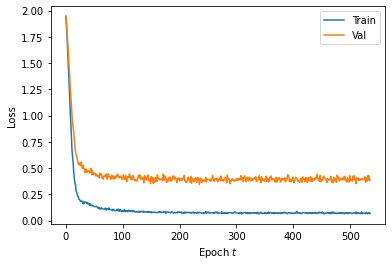

In [3]:
train_statistics = experiment_train.run(
    data_dir = './data',
    dataset = 'cora_ml',
    model_params = dict(
        label="Vanilla GCN", 
        model="GCN", 
        do_cache_adj_prep=True, 
        n_filters=64, 
        dropout=0.5, 
        svd_params=None, 
        jaccard_params=None, 
        gdc_params={"alpha": 0.15, "k": 64}),
    train_params = dict(
        lr=1e-2,
        weight_decay=1e-3,
        patience=300,
        max_epochs=3000),
    binary_attr = False,
    make_undirected = True,
    seed=0,
    artifact_dir = 'cache',
    model_storage_type = 'demo',
    ppr_cache_params = dict(),
    device = 0,
    data_device = 0,
    display_steps = 100,
    debug_level = "info"     
)

# plot train and val loss curves
fig, ax = plt.subplots()

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
ax.set_xlabel('Epoch $t$')
ax.set_ylabel("Loss")
ax.plot(train_statistics['trace_train'], color=color, label='Train')

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(train_statistics['trace_val'], color=color, label='Val')
ax.legend()

plt.gcf().show()

In [4]:
clean_acc = train_statistics["accuracy"]
print(f'Accuracy of the model: {100*clean_acc:.2f}%')

Accuracy of the model: 81.90%


## 2. Evaluation

For evaluation, we use the locally stored models. Similarly to training, we provide a script that runs the attacks for different seeds for all pretrained models. For all experiments, please check out the [config](https://github.com/sigeisler/robustness_of_gnns_at_scale/tree/main/config) folder.

### 2.1 Local PR-BCD Attack
We provide an example for a `local PR-BCD` attack on the `Vanilla GCN` model trained previously by passing the desired configuration in [experiments/experiment_local_attack_direct.py](https://github.com/sigeisler/robustness_of_gnns_at_scale/blob/main/experiments/experiment_local_attack_direct.py#L68).

In [5]:
local_prbcd_statistics = experiment_local_attack_direct.run(
    data_dir = './data',
    dataset = 'cora_ml',
    attack = 'LocalPRBCD',
    attack_params = dict(
        ppr_cache_params = dict(
            data_artifact_dir = 'cache',
            data_storage_type = 'ppr'),
        epochs = 500,
        fine_tune_epochs = 100,
        search_space_size = 10_000,
        ppr_recalc_at_end = True,
        loss_type = 'Margin',
        lr_factor = 0.05),
    nodes = None,
    nodes_topk = 5,
    seed=0,
    epsilons = [1],
    min_node_degree = None,
    binary_attr = False,
    make_undirected = True,
    artifact_dir = 'cache',
    model_label = 'Vanilla GCN',
    model_storage_type = 'demo',
    device = 0,
    data_device = 0,
    debug_level = "info"     
)

2022-04-20 17:05:39 (INFO): {'dataset': 'cora_ml', 'attack': 'LocalPRBCD', 'attack_params': {'ppr_cache_params': {'data_artifact_dir': 'cache', 'data_storage_type': 'ppr'}, 'epochs': 500, 'fine_tune_epochs': 100, 'search_space_size': 10000, 'ppr_recalc_at_end': True, 'loss_type': 'Margin', 'lr_factor': 0.05}, 'epsilons': [1], 'make_undirected': True, 'binary_attr': False, 'seed': 0, 'artifact_dir': 'cache', 'pert_adj_storage_type': None, 'pert_attr_storage_type': None, 'model_label': 'Vanilla GCN', 'model_storage_type': 'demo', 'device': 0, 'data_device': 0}
2022-04-20 17:05:39 (INFO): Lock 139753357381712 acquired on cache/demo.json.lock
2022-04-20 17:05:39 (INFO): Lock 139753357381712 released on cache/demo.json.lock
2022-04-20 17:05:39 (INFO): Found 1 models with label 'Vanilla GCN' to attack.
2022-04-20 17:05:39 (INFO): Sample Attack Nodes for model with accuracy 0.819
2022-04-20 17:05:39 (INFO): Found 2530 suitable '1+ degree' nodes out of 2530 candidate nodes to be sampled from f

In [6]:
n_change = 0
for node in local_prbcd_statistics['results']:
    if node['margin'] < 0:
        n_change += 1
flipped_ratio =  n_change / len(local_prbcd_statistics['results'])
print(f'Percentage of changed node predictions : {100*flipped_ratio:.2f}%')

Percentage of changed node predictions : 100.00%


### 2.2 Global PR-BCD Attack

Now let's do the same with a non-local `PR-BCD` attack. For this, we use [experiments/experiment_global_attack_direct.py](https://github.com/sigeisler/robustness_of_gnns_at_scale/blob/main/experiments/experiment_global_attack_direct.py#L63).

In [7]:
global_prbcd_statistics = experiment_global_attack_direct.run(
    data_dir = './data',
    dataset = 'cora_ml',
    attack = 'PRBCD',
    attack_params = dict(
        epochs=500,
        fine_tune_epochs=100,
        keep_heuristic="WeightOnly",
        search_space_size=100_000,
        do_synchronize=True,
        loss_type="tanhMargin",
    ),
    epsilons = [0.25],
    binary_attr = False,
    make_undirected = True,
    seed=0,
    artifact_dir = 'cache',
    pert_adj_storage_type = 'evasion_global_adj',
    pert_attr_storage_type = 'evasion_global_attr',
    model_label = 'Vanilla GCN',
    model_storage_type = 'demo',
    device = 0,
    data_device = 0,
    debug_level = "info"     
)

print(global_prbcd_statistics)

2022-04-20 17:20:10 (INFO): {'dataset': 'cora_ml', 'attack': 'PRBCD', 'attack_params': {'epochs': 500, 'fine_tune_epochs': 100, 'keep_heuristic': 'WeightOnly', 'search_space_size': 100000, 'do_synchronize': True, 'loss_type': 'tanhMargin'}, 'epsilons': [0.25], 'make_undirected': True, 'binary_attr': False, 'seed': 0, 'artifact_dir': 'cache', 'pert_adj_storage_type': 'evasion_global_adj', 'pert_attr_storage_type': 'evasion_global_attr', 'model_label': 'Vanilla GCN', 'model_storage_type': 'demo', 'device': 0, 'data_device': 0}
2022-04-20 17:20:10 (INFO): Lock 139753343279952 acquired on cache/demo.json.lock
2022-04-20 17:20:10 (INFO): Lock 139753343279952 released on cache/demo.json.lock
2022-04-20 17:20:10 (INFO): Evaluate  PRBCD for model 'Vanilla GCN'.
2022-04-20 17:20:10 (INFO): Lock 139753348178960 acquired on cache/evasion_global_adj.json.lock
2022-04-20 17:20:10 (INFO): Lock 139753348178960 released on cache/evasion_global_adj.json.lock
2022-04-20 17:20:10 (INFO): Lock 13975334338

{'results': [{'label': 'Vanilla GCN', 'epsilon': 0.25, 'accuracy': 0.522529661655426}]}


In [9]:
perturbed_acc = global_prbcd_statistics["results"][0]['accuracy']
print(f'Clean accuracy: {100*clean_acc:.2f}%; Accuracy after global PRBCD attack: {100*perturbed_acc:.2f}%')

Clean accuracy: 81.90%; Accuracy after global PRBCD attack: 52.25%
